##SVD and NMF with Surprise

#### Import Libraries

In [212]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import numpy as np

In [197]:
import surprise
from surprise import SVD
from surprise import NMF
from surprise import Dataset
from surprise import evaluate, print_perf, GridSearch
from surprise import Reader
from surprise import accuracy

In [10]:
import ast
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [ ]:
from scipy.stats import spearmanr
from collections import defaultdict

#### Import Data

In [4]:
ratings = pd.read_csv('../ratings.csv')

In [ ]:
ratings.head()

In [ ]:
n_ratings = len(ratings)
print('Number of ratings: {}'.format(n_ratings))

# new start

In [168]:
def pick_users_books(df, num_users, num_books):
    user_counts = pd.DataFrame(df.user_id.value_counts()).sort_values('user_id', ascending=False)
    top_10K_users = list(user_counts[0:num_users].index)
    user_filtered_df = df[df.user_id.isin(top_10K_users)]
    filtered_book_counts = pd.DataFrame(user_filtered_df.book_id.value_counts()).sort_values('book_id', ascending = False)
    top_100_filtered_books = list(filtered_book_counts[0:num_books].index)
    filtered_df = user_filtered_df[user_filtered_df.book_id.isin(top_100_filtered_books)]
    print("New dataframe has {} users, {} items, and a sparsity of {}".format(len(filtered_df.user_id.unique()),len(filtered_df.book_id.unique()),len(filtered_df)/(len(filtered_df.user_id.unique())*len(filtered_df.book_id.unique()))))
    train, test = train_test_split(filtered_df, test_size = 0.2, random_state=42)
    return filtered_df, train, test


def get_all_subsets(df):
    full_500_20, train_500_20, test_500_20 = pick_users_books(df, 500, 20)
    full_1000_35, train_1000_35, test_1000_35 = pick_users_books(df, 1000, 35)
    full_2000_50, train_2000_50, test_2000_50 = pick_users_books(df, 2000, 50)
    full_5000_70, train_5000_70, test_5000_70 = pick_users_books(df, 5000, 70)
    full_7500_85, train_7500_85, test_7500_85 = pick_users_books(df, 7500, 85)
    full_10000_100, train_10000_100, test_10000_100 = pick_users_books(df, 10000, 100)
    return full_500_20, train_500_20, test_500_20, \
full_1000_35, train_1000_35, test_1000_35, \
full_2000_50, train_2000_50, test_2000_50, \
full_5000_70, train_5000_70, test_5000_70, \
full_7500_85, train_7500_85, test_7500_85, \
full_10000_100, train_10000_100, test_10000_100

In [170]:
full_500_20, train_500_20, test_500_20, \
full_1000_35, train_1000_35, test_1000_35, \
full_2000_50, train_2000_50, test_2000_50, \
full_5000_70, train_5000_70, test_5000_70, \
full_7500_85, train_7500_85, test_7500_85, \
full_10000_100, train_10000_100, test_10000_100 = get_all_subsets(ratings)

New dataframe has 487 users, 20 items, and a sparsity of 0.44260780287474333
New dataframe has 985 users, 35 items, and a sparsity of 0.4041189267585207
New dataframe has 1981 users, 50 items, and a sparsity of 0.3745583038869258
New dataframe has 4980 users, 70 items, and a sparsity of 0.32403614457831326
New dataframe has 7479 users, 85 items, and a sparsity of 0.2953682074514523
New dataframe has 9980 users, 100 items, and a sparsity of 0.2719659318637275


In [245]:
# marika functions

def spearman(predictions):
    dict_ratings = {}
    spearmans = []
    for uid, iid, true_r, est, _ in predictions:
        if float(true_r) and float(est) and not np.isnan(true_r) and not np.isnan(est):
            if uid in dict_ratings.keys():
                dict_ratings[uid][0].append(true_r)
                dict_ratings[uid][1].append(est)
            else:
                dict_ratings[uid]=[[true_r],[est]]
    for uid in dict_ratings.keys():
        if len(dict_ratings[uid][0])>1:
            spearman = spearmanr(dict_ratings[uid][0], dict_ratings[uid][1])[0]
            if np.isnan(spearman) == False: # spearman is NaN if all true ratings are the same! exclude these
                spearmans.append(spearman)
    return np.mean(spearmans)

def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

def calc_item_coverage(top_n, num_books):
    bookset = set()
    for book in top_n.keys():
        for pair in top_n[book]:
            bookset.add(pair[0])
    return float(len(bookset))/num_books

Additional iterations of the SVD algorithm (‘n_epochs’) had a clear, positive impact on performance (lower RMSE and MAE) as did additional factors (‘n_factors’), though to a lesser extent. We also tried biased vs. non-biased and found that adding a bias term for users and items always performed better.

In [ ]:
# SVD Grid Search run. The following sets of paramters were tested:

param_grid = {'n_factors': [100,150],'n_epochs': [20,40], 'lr_all': [0.015,0.03,0.045],
              'reg_all': [0.025,0.05,0.075]}

param_grid = {'n_factors': [150],'n_epochs': [40], 'lr_all': [0.01,0.02,0.03],
              'reg_all': [0.05,0.075,0.1]}

param_grid = {'n_factors': [125,150,175],'n_epochs': [30,40,50],\
              'lr_all': [0.0225],'reg_all': [0.08]}

param_grid = {'n_factors': [160,180,200],'n_epochs': [45,55,65],\
              'lr_all': [0.0225],'reg_all': [0.08]}

param_grid = {'n_factors': [150],'n_epochs': [40], 'lr_all': [0.015],
              'reg_all': [.005,0.01,0.015,0.02,0.025,0.03,\
                          0.035,0.04,0.045,0.05,0.055, 0.06,\
                         0.065,0.07,0.075,0.08,0.085, 0.09,\
                         0.095,0.1,0.105,0.11,0.115, 0.12,\
                         0.125,0.13,0.135,0.14,0.145, 0.15]}

param_grid = {'n_factors': [150],'n_epochs': [40],\
              'lr_all': [0.0025,0.005,0.0075,\
                         0.01,0.0125,0.015,0.0175,\
                         0.02,0.0225,0.025,0.0275,\
                         0.03,0.0325,0.035,0.0375,0.04],
              'reg_all': [0.08]}

In [175]:
# SVD grid search

reader = Reader(rating_scale=(1, 5))

param_grid = {'n_factors': [100,150,200],'n_epochs': [50],\
              'lr_all': [0.0225],'reg_all': [0.08]}

grid_search = GridSearch(SVD, param_grid, measures=[u'rmse', u'mae'], verbose=1)

sur_data = Dataset.load_from_df(train_10000_100[['user_id','book_id','rating']], reader)
sur_data.split(3)  # data can now be used normally

grid_search.evaluate(sur_data)

[{'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.0225, 'reg_all': 0.08}]
------------
Parameters combination 1 of 1
params:  {'n_factors': 200, 'n_epochs': 50, 'lr_all': 0.0225, 'reg_all': 0.08}
------------
Mean RMSE: 0.8525
Mean MAE : 0.6605
------------


In [249]:
# after copying and pasting the above output to a txt file, i used the following code to
# read the output and create a table with all the different runs and their corresponding
# RMSE and MAE values

result_df = pd.DataFrame(columns=['lr_all', 'n_epochs', 'n_factors', 'reg_all','RMSE','MAE'])

file = open('../SVD_reg_plot.txt', 'r') 
for line in file:
    if line[0:9] == 'Mean RMSE':
        new_dict['RMSE'] = float(line.split(":")[1])
    if line[0:8] == 'Mean MAE':
        new_dict['MAE'] = float(line.split(":")[1])
#         if new_dict['biased'] == False:
#             new_dict['biased'] = 0
#         else:
#             new_dict['biased'] = 1
        result_df = pd.concat([result_df,pd.DataFrame([new_dict])])
    if line[0:7] == 'params:':
        new_dict = ast.literal_eval(line.split("params:  ")[1])

The rate at which the algorithm learns (lr_all) and the size of the regularization term (reg_all) had a less clear impact on performance. It seems that with a slower learning rate, a higher penalty (regularization parameter) works better, and vice versa. After investigating some of the grid search outputs, we settled on a number of factors and epochs, which have a lower impact on accuracy, in order to test regularization and learning rate more granularly. The following plots show how regularization and learning rate affect the RMSE. 

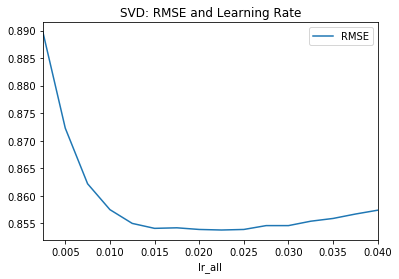

In [248]:
# to plot how changes in learning rate affect RMSE
# requires the txt file from the SVD_learning rate run

result_df.sort_values('lr_all').plot('lr_all','RMSE')
plt.title('SVD: RMSE and Learning Rate')

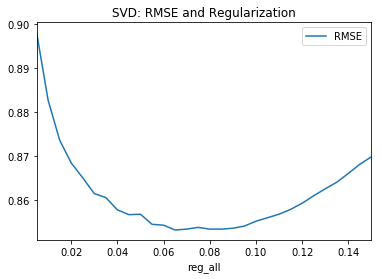

In [250]:
# to plot how changes in regularization affect RMSE
# requires the txt file from the SVD_regularization rate run

result_df.sort_values('reg_all').plot('reg_all','RMSE')
plt.title('SVD: RMSE and Regularization')

In [152]:
# sorting the output by RMSE

result_df.sort_values('RMSE').head(10)

,MAE,RMSE,lr_all,n_epochs,n_factors,reg_all
0,0.6610,0.8542,0.02,40,150,0.075
0,0.6635,0.8552,0.02,40,150,0.100
0,0.6622,0.8556,0.03,40,150,0.075
0,0.6623,0.8560,0.03,40,150,0.050
0,0.6620,0.8562,0.02,40,150,0.050
0,0.6644,0.8569,0.03,40,150,0.100
0,0.6658,0.8578,0.01,40,150,0.075
0,0.6651,0.8597,0.01,40,150,0.050
0,0.6721,0.8625,0.01,40,150,0.100


In [177]:
# single SVD run

start_time = (datetime.datetime.now())

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))
# The columns must correspond to user id, item id and ratings (in that order).
sur_data = Dataset.load_from_df(full_10000_100[['user_id','book_id','rating']], reader)
sur_data.split(3)  # data can now be used normally

algo = SVD(n_factors =  150, n_epochs = 50, lr_all =  0.0225,
              reg_all =  0.08)

# Evaluate performances of our algorithm on the dataset.
perf = evaluate(algo, sur_data, measures=['RMSE', 'MAE'])

print_perf(perf)

stop_time = (datetime.datetime.now())
print(stop_time - start_time)

Evaluating RMSE, MAE of algorithm SVD.

------------
Fold 1
RMSE: 0.8579
MAE:  0.6621
------------
Fold 2
RMSE: 0.8506
MAE:  0.6601
------------
Fold 3
RMSE: 0.8515
MAE:  0.6603
------------
------------
Mean RMSE: 0.8533
Mean MAE : 0.6608
------------
------------
        Fold 1  Fold 2  Fold 3  Mean    
RMSE    0.8579  0.8506  0.8515  0.8533  
MAE     0.6621  0.6601  0.6603  0.6608  
0:01:25.785883


In [213]:
# output for accuracy and time tables

def SVD_test(sample):
    #Capture start time
    start_time = time.time()

    #set up reader and get data from dataframe
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(sample[['user_id', 'book_id', 'rating']], reader)

    #Split data into training set, testing set, and the anti-test set (all the items neither in test nor train)
    trainset = data.build_full_trainset()
    testset = trainset.build_testset()
    antitestset = trainset.build_anti_testset()

    #Set up algorithm

    algo = SVD(n_factors =  200, n_epochs = 50, lr_all =  0.0225,
                  reg_all =  0.08)

    #Train algorithm
    algo.train(trainset)

        #Print algorithm time
        
    print("--- %s seconds ---" % (time.time() - start_time))
    next_time = time.time()
    
    #Get predictions
    predictions = algo.test(testset)

    print("--- %s seconds ---" % (time.time() - next_time))
    
    #Evaluate accuracy measures
    accuracy.rmse(predictions, verbose=True)
    accuracy.mae(predictions, verbose=True)
    accuracy.fcp(predictions, verbose=True)
    spman = spearman(predictions)
    print("SPEARMAN:  {}".format(spman))
    

In [216]:
for i in (full_500_20,full_1000_35,full_2000_50,full_5000_70,full_7500_85,full_10000_100):
    SVD_test(i)

--- 0.9952630996704102 seconds ---
RMSE: 0.2795
MAE:  0.2156
FCP:  0.9602


/Users/marksalama/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/marksalama/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


SPEARMAN:  0.8746993336176473
--- 0.30649590492248535 seconds ---
--- 3.2643730640411377 seconds ---
RMSE: 0.3475
MAE:  0.2645
FCP:  0.9620
SPEARMAN:  0.8688140280272801
--- 0.604604959487915 seconds ---
--- 8.65052318572998 seconds ---
RMSE: 0.4013
MAE:  0.3054
FCP:  0.9574
SPEARMAN:  0.8686647295845686
--- 1.3693420886993408 seconds ---
--- 28.251965284347534 seconds ---
RMSE: 0.4522
MAE:  0.3447
FCP:  0.9513
SPEARMAN:  0.8622719182611005
--- 4.674900054931641 seconds ---
--- 48.53049826622009 seconds ---
RMSE: 0.4753
MAE:  0.3645
FCP:  0.9452
SPEARMAN:  0.8583539076590213
--- 7.165470361709595 seconds ---
--- 69.29260802268982 seconds ---
RMSE: 0.4972
MAE:  0.3824
FCP:  0.9385
SPEARMAN:  0.849745270100673
--- 9.73905897140503 seconds ---


# NMF

In [ ]:
#NMF Grid Search run. The following sets of paramters were tested:
param_grid = {'n_factors': [15,30],'n_epochs': [40,70], 'lr_bu': [0.004,0.008], 'lr_bi': [0.004,0.008],
              'reg_pu': [0.05,0.07], 'reg_qi': [0.05,0.07]}

param_grid = {'n_factors': [30,45],'n_epochs': [70,100], 'lr_bu': [0.007,0.008], 'lr_bi': [0.007,0.008],
              'reg_pu': [0.07,0.08], 'reg_qi': [0.07,0.08]}


param_grid = {'n_factors': [40,50],'n_epochs': [60,80], 'lr_bu': [0.0075,0.0085], 'lr_bi': [0.0075,0.0085],
              'reg_pu': [0.075,0.085], 'reg_qi': [0.075,0.085]}

param_grid = {'n_factors': [50,60],'n_epochs': [80,90], 'lr_bu': [0.0085], 'lr_bi': [0.0085],
              'reg_pu': [0.085], 'reg_qi': [0.085]}

param_grid = {'n_factors': [60],'n_epochs': [80], 'lr_bu': [0.01,0.011,0.012],
              'lr_bi': [0.01,0.011,0.012], 'reg_pu': [0.05,0.07,0.09],
              'reg_qi': [0.05,0.07,0.09]}

Performing a similar grid search with NMF through Surprise quickly revealed a few insights. Starting from the defaults, higher latent factors and higher iterations nearly always outperformed At least in the set of initial parameters tested, the regularization term is more important than the learning rate. Further tests showed that as with SVD, higher regularization pairs better with lower learning rates, and vice versa.

In [222]:
#NMF Grid Search
reader = Reader(rating_scale=(1, 5))

param_grid = {'n_factors': [60],'n_epochs': [80], 'lr_bu': [0.01,0.011,0.012], 'lr_bi': [0.01,0.011,0.012], 'reg_pu': [0.05,0.07,0.09], 'reg_qi': [0.05,0.07,0.09]}

grid_search = GridSearch(NMF, param_grid, measures=[u'rmse', u'mae'], verbose=1)

sur_data = Dataset.load_from_df(train_10000_100[['user_id','book_id','rating']], reader)
sur_data.split(3)  # data can now be used normally

grid_search.evaluate(sur_data)

[{'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.05, 'reg_qi': 0.05}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.05, 'reg_qi': 0.07}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.05, 'reg_qi': 0.09}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.07, 'reg_qi': 0.05}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.07, 'reg_qi': 0.07}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.07, 'reg_qi': 0.09}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.09, 'reg_qi': 0.05}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.09, 'reg_qi': 0.07}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.09, 'reg_qi': 0.09}, {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.011, 'reg_pu': 0.05, 'reg_qi': 0.05}, {'n_factors': 60, 'n_epochs'

------------
Mean RMSE: 0.8933
Mean MAE : 0.6778
------------
------------
Parameters combination 3 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.05, 'reg_qi': 0.09}
------------
Mean RMSE: 0.8857
Mean MAE : 0.6791
------------
------------
Parameters combination 4 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.07, 'reg_qi': 0.05}
------------
Mean RMSE: 0.8938
Mean MAE : 0.6783
------------
------------
Parameters combination 5 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.07, 'reg_qi': 0.07}
------------
Mean RMSE: 0.8855
Mean MAE : 0.6827
------------
------------
Parameters combination 6 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.01, 'lr_bi': 0.01, 'reg_pu': 0.07, 'reg_qi': 0.09}
------------
Mean RMSE: 0.8828
Mean MAE : 0.6866
------------
------------
Parameters combination 7 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu'

------------
Mean RMSE: 0.8849
Mean MAE : 0.6816
------------
------------
Parameters combination 42 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.011, 'lr_bi': 0.011, 'reg_pu': 0.07, 'reg_qi': 0.09}
------------
Mean RMSE: 0.8824
Mean MAE : 0.6860
------------
------------
Parameters combination 43 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.011, 'lr_bi': 0.011, 'reg_pu': 0.09, 'reg_qi': 0.05}
------------
Mean RMSE: 0.8878
Mean MAE : 0.6835
------------
------------
Parameters combination 44 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.011, 'lr_bi': 0.011, 'reg_pu': 0.09, 'reg_qi': 0.07}
------------
Mean RMSE: 0.8834
Mean MAE : 0.6877
------------
------------
Parameters combination 45 of 81
params:  {'n_factors': 60, 'n_epochs': 80, 'lr_bu': 0.011, 'lr_bi': 0.011, 'reg_pu': 0.09, 'reg_qi': 0.09}
------------
Mean RMSE: 0.8823
Mean MAE : 0.6915
------------
------------
Parameters combination 46 of 81
params:  {'n_factors': 60, 'n_epochs'

KeyboardInterrupt: 

In [251]:
# after copying and pasting the above output to a txt file, i used the following code to
# read the output and create a table with all the different runs and their corresponding
# RMSE and MAE values


result_df = pd.DataFrame(columns=['n_epochs', 'n_factors', 'lr_bu', 'lr_bi' , 'reg_pu', 'reg_qi', 'RMSE','MAE'])

file = open('../NMF_primary5.txt', 'r') 
for line in file:
    if line[0:9] == 'Mean RMSE':
        new_dict['RMSE'] = float(line.split(":")[1])
    if line[0:8] == 'Mean MAE':
        new_dict['MAE'] = float(line.split(":")[1])
#         if new_dict['biased'] == False:
#             new_dict['biased'] = 0
#         else:
#             new_dict['biased'] = 1
        result_df = pd.concat([result_df,pd.DataFrame([new_dict])])
    if line[0:7] == 'params:':
        new_dict = ast.literal_eval(line.split("params:  ")[1])

In [252]:
# results sorted by RMSE
result_df.sort_values('RMSE').head(10)

,MAE,RMSE,lr_bi,lr_bu,n_epochs,n_factors,reg_pu,reg_qi
0,0.6848,0.8812,0.012,0.011,80,60,0.07,0.09
0,0.6897,0.8814,0.012,0.011,80,60,0.09,0.09
0,0.6907,0.8818,0.010,0.011,80,60,0.09,0.09
0,0.6908,0.8820,0.012,0.010,80,60,0.09,0.09
0,0.6909,0.8821,0.011,0.010,80,60,0.09,0.09
0,0.6858,0.8823,0.010,0.011,80,60,0.07,0.09
0,0.6915,0.8823,0.011,0.011,80,60,0.09,0.09
0,0.6860,0.8824,0.011,0.011,80,60,0.07,0.09
0,0.6864,0.8826,0.011,0.010,80,60,0.07,0.09
0,0.6863,0.8826,0.012,0.010,80,60,0.07,0.09


In [300]:
# output for accuracy and timing tables using optimal parameters established above

def NMF_test(sample):
    result_dict = {}
    #Capture start time
    start_time = time.time()

    #set up reader and get data from dataframe
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(sample[['user_id', 'book_id', 'rating']], reader)

    #Split data into training set, testing set, and the anti-test set (all the items neither in test nor train)
    trainset = data.build_full_trainset()
    testset = trainset.build_testset()
    antitestset = trainset.build_anti_testset()

    #Set up algorithm

    algo = NMF(n_factors = 60, n_epochs=  80, lr_bu = 0.0085, lr_bi = 0.00085,
              reg_pu = 0.085, reg_qi = 0.085)

    #Train algorithm
    algo.train(trainset)

        #Print algorithm time
        
    print("--- %s seconds ---" % (time.time() - start_time))
    
    result_dict['time_train'] = (time.time() - start_time)

    next_time = time.time()
    
    #Get predictions
    predictions = algo.test(testset)

    print("--- %s seconds ---" % (time.time() - next_time))
    
    result_dict['time_test'] = (time.time() - next_time)
    
    #Evaluate accuracy measures
#     accuracy.rmse(predictions, verbose=True)
#     accuracy.mae(predictions, verbose=True)
#     accuracy.fcp(predictions, verbose=True)
#     spman = spearman(predictions)
#     print("SPEARMAN:  {}".format(spman))

    result_dict['RMSE'] = float(accuracy.rmse(predictions, verbose=True))
    result_dict['MAE'] = float(accuracy.mae(predictions, verbose=True))
    result_dict['FCP'] = float(accuracy.fcp(predictions, verbose=True))
    result_dict['Spearman'] = float(spearman(predictions))
    
    return result_dict
    

In [298]:
result_dict = {}
result_dict['RMSE'] = accuracy.rmse(predictions, verbose=True)
result_dict['MAE'] = accuracy.mae(predictions, verbose=True)
result_dict['FCP'] = accuracy.fcp(predictions, verbose=True)
result_dict['Spearman'] = spearman(predictions)

RMSE: 0.4971
MAE:  0.3823
FCP:  0.9389


/Users/marksalama/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/marksalama/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


In [297]:
mark = accuracy.rmse(predictions, verbose=True))

RMSE: 0.4971


0.4970722566524826

In [260]:
for i,x in enumerate(book_list):
    print (x)

20
35
50
70
85
100


In [301]:
output_df = pd.DataFrame(columns=['books','time_train', 'RMSE', 'MAE', 'Spearman', 'time_test'])
book_list = [20,35,50,70,85,100]

# test_sets = [full_500_20,full_1000_35,full_2000_50,full_5000_70,full_7500_85,full_10000_100]
test_sets = [full_500_20,full_1000_35,full_2000_50]

for i,x in enumerate(test_sets):
    result_dict = NMF_test(x)
#     result_dict['books'] = book_list[i]
    output_df = pd.concat([output_df,pd.DataFrame([result_dict])])


--- 0.8606929779052734 seconds ---
--- 0.03710293769836426 seconds ---
RMSE: 0.3470
MAE:  0.2536
FCP:  0.9267


/Users/marksalama/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3003: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/marksalama/anaconda/lib/python3.6/site-packages/numpy/lib/function_base.py:3004: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:879: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/Users/marksalama/anaconda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1818: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


--- 2.813260793685913 seconds ---
--- 0.07932686805725098 seconds ---
RMSE: 0.4486
MAE:  0.3334
FCP:  0.9357
--- 7.327859878540039 seconds ---
--- 1.057865858078003 seconds ---
RMSE: 0.5223
MAE:  0.3934
FCP:  0.9129


In [299]:
output_df

,books,time_train,RMSE,MAE,Spearman,time_test,0
0,NaN,NaN,NaN,NaN,NaN,NaN,None
0,NaN,NaN,NaN,NaN,NaN,NaN,None
0,NaN,NaN,NaN,NaN,NaN,NaN,None


## coverage

In [270]:
# select the algorithm and then run item coverage

algo = NMF(n_factors = 60, n_epochs=  80, lr_bu = 0.0085, lr_bi = 0.00085,
              reg_pu = 0.085, reg_qi = 0.085)

# algo = SVD(n_factors =  200, n_epochs = 50, lr_all =  0.0225,
#                   reg_all =  0.08)

return_coverage(algo)

COVERAGE FOR TOP 5: 0.93
COVERAGE FOR TOP 10: 0.98
COVERAGE FOR TOP 15: 1.0
COVERAGE FOR TOP 20: 1.0


In [242]:
# coverage function
def return_coverage(algo):
    #Get coverage for different values of n on the largest subset

    n_ratings = len(full_10000_100)
    num_users = len(full_10000_100.user_id.unique())
    num_books = len(full_10000_100.book_id.unique())

    #set up reader and get data from dataframe
    reader = Reader(rating_scale=(1, 5))
    data = Dataset.load_from_df(full_10000_100[['user_id', 'book_id', 'rating']], reader)

    #Split data into training set, testing set, and the anti-test set (all the items neither in test nor train)
    trainset = data.build_full_trainset()
    antitestset = trainset.build_anti_testset()

#     #Set up algorithm
#     algo = algo

    #Train algorithm
    algo.train(trainset)

    #Estimate unknown ratings
    true_predictions = algo.test(antitestset)

    #Get top n recommendations
    ns=[5,10,15,20]

    for n in ns:
        top_n = get_top_n(true_predictions, n)
        print("COVERAGE FOR TOP {}: {}".format(n,calc_item_coverage(top_n, num_books)))